In [1]:
#| default_exp hedgerprep

# Documentation
## Datasets
* xdf: raw data 

In [2]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from fastai.tabular.all import *
import nbdev
import gzip

In [3]:
#| export
def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

# Parameters

In [4]:
#| export

stop_loss_tick = 2
tick_size = 0.01

if is_notebook():
    data_dir = Path("../market")
    save_dir = Path("../market/save")
    market_open = "09:30"
    rows_to_load = 3_000_000     # should be -1 for training, or positive smaller for faster testing
    load_date = "20250103"

    day_sample_count = 5000
    print("Running in Jupyter Notebook")
else:
    data_dir = Path("../market")
    save_dir = Path("../market/save")
    market_open = "09:30"
    rows_to_load = -1     # should be -1 for training, or positive smaller for faster testing

    day_sample_count = 5000


Running in Jupyter Notebook


# Load data

In [5]:
#| export
def load_data(date):
    file_path = data_dir / f"xnas-itch-{date}.mbp-10.csv"
    if not file_path.exists():
        file_path = data_dir / f"xnas-itch-{date}.mbp-10.csv.gz"
        if file_path.exists():
            with gzip.open(file_path, 'rb') as f:
                decompressed_data = f.read()
            df = pd.read_csv(io.BytesIO(decompressed_data), nrows=rows_to_load if rows_to_load > 0 else None)
        else:
            raise FileNotFoundError(f"Neither {file_path} nor its .gz version exists.")
    else:
        df = pd.read_csv(file_path, nrows=rows_to_load if rows_to_load > 0 else None)
    return df

In [6]:
xdf = load_data(load_date)
xdf.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
0,2025-01-03T09:00:00.015869440Z,2025-01-03T09:00:00.015702539Z,10,2,11667,A,N,0,140.97,100,...,0,0,0,NaN,NaN,0,0,0,0,NVDA
1,2025-01-03T09:00:00.015938794Z,2025-01-03T09:00:00.015771793Z,10,2,11667,A,B,0,137.50,10000,...,0,0,0,NaN,NaN,0,0,0,0,NVDA
2,2025-01-03T09:00:00.040850395Z,2025-01-03T09:00:00.040665733Z,10,2,11667,A,A,1,157.05,73,...,0,0,0,NaN,NaN,0,0,0,0,NVDA
3,2025-01-03T09:00:00.059865276Z,2025-01-03T09:00:00.059698561Z,10,2,11667,A,A,0,138.81,1000,...,0,0,0,NaN,NaN,0,0,0,0,NVDA
4,2025-01-03T09:00:00.085513156Z,2025-01-03T09:00:00.085346759Z,10,2,11667,A,B,1,121.00,20,...,0,0,0,NaN,NaN,0,0,0,0,NVDA


#### Adjust timestamps + drop outside market hours

In [7]:
#| export
def adjust_for_time(df):
    df["ts_event"] = pd.to_datetime(df.ts_event, unit="ns")
    df["ts_event"] = df["ts_event"].dt.tz_convert('US/Eastern')
    df = df[df["ts_event"].dt.time >= pd.to_datetime("09:30").time()]
    df = df[df["ts_event"].dt.time <= pd.to_datetime("16:00").time()]
    #df.set_index('ts_event', inplace=True)

    market_open = pd.to_datetime("09:30").time()
    print(market_open)
    df['ns_since_open'] = (df['ts_event'] - df['ts_event'].dt.normalize() - pd.to_timedelta(market_open.hour, unit='h') - pd.to_timedelta(market_open.minute, unit='m')).dt.total_seconds() * 1e9 + df['ts_event'].dt.nanosecond

    df = add_datepart(df, 'ts_event', drop=False)
    return df

In [8]:
xdf = adjust_for_time(xdf)
' '.join(o for o in xdf.columns if o.startswith('ts_event'))


09:30:00


'ts_event ts_eventYear ts_eventMonth ts_eventWeek ts_eventDay ts_eventDayofweek ts_eventDayofyear ts_eventIs_month_end ts_eventIs_month_start ts_eventIs_quarter_end ts_eventIs_quarter_start ts_eventIs_year_end ts_eventIs_year_start ts_eventElapsed'

#### Cleanup (drop rows with NA)

In [9]:
#| export
def drop_na(df):
    orig_len = df.shape[0]
    df.dropna(inplace=True)
    cur_len = df.shape[0]
    drop_cnt = orig_len-cur_len
    if  drop_cnt > 1000:
        raise Exception(f"{drop_cnt} rows dropped, seems a lot")
    else:
        print(f"{drop_cnt} dropped out of {orig_len}")

In [10]:
drop_na(xdf)

0 dropped out of 2919224


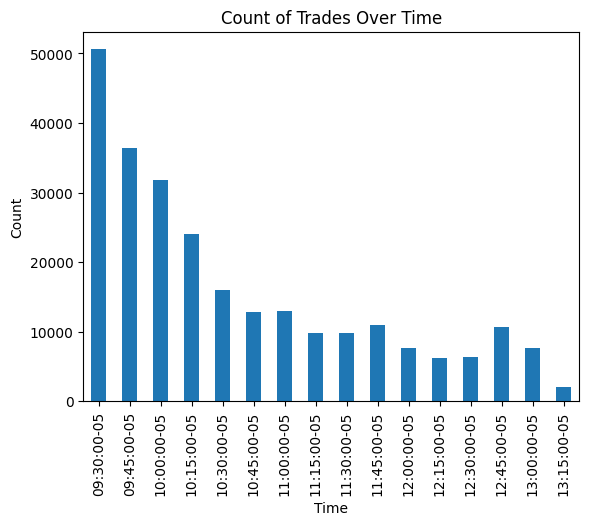

In [11]:
# Filter the dataframe for action "T"
df_trades = xdf[xdf['action'] == "T"]

# Group by buckets of 15 minutes
df_trades.set_index('ts_event').resample('15min').size().plot(kind='bar', title='Count of Trades Over Time')
plot.xlabel('Time')
#plot.xticks(rotation=45)
labels = [item.get_text().split(' ')[1].split('+')[0][:-3] for item in plot.gca().get_xticklabels()]
plot.gca().set_xticklabels(labels)
plot.ylabel('Count')
plot.show()

In [12]:
trades = xdf[(xdf.action == "T") & (xdf.side != "N")]
cols = ["action", "side", "price", "size", "bid_sz_00", "bid_px_00", "ask_px_00", "ask_sz_00",
         "bid_sz_01", "bid_px_01", "ask_px_01", "ask_sz_01","sequence"]
trades.side.value_counts()


side
B    115764
A     91712
Name: count, dtype: int64

In [13]:
def display_around(idx, nbrows=6):
    iloc_index = xdf.index.get_loc(idx)
    print(iloc_index)
    return xdf.iloc[iloc_index-1:iloc_index+nbrows-1][cols]
idx = 0

In [14]:
x = display_around(trades.index[idx])
print(idx, trades.index[idx])
idx = idx + 1
x

1
0 80777


,action,side,price,size,bid_sz_00,bid_px_00,ask_px_00,ask_sz_00,bid_sz_01,bid_px_01,ask_px_01,ask_sz_01,sequence
80776,T,N,140.03,1,1479,140.0,140.05,50,50,139.96,140.06,4017,21892058
80777,T,A,140.00,259,1479,140.0,140.05,50,50,139.96,140.06,4017,21892059
80778,C,B,140.00,259,1220,140.0,140.05,50,50,139.96,140.06,4017,21892059
80779,C,A,140.05,30,1220,140.0,140.05,20,50,139.96,140.06,4017,21892146
80780,C,B,139.91,400,1320,140.0,140.05,20,50,139.96,140.06,4017,21892148
80781,A,N,140.00,100,1420,140.0,140.05,50,50,139.96,140.06,4017,21893860


#### Add spread

In [15]:
#| export
def add_spread(df):
    df['spread'] = (df['ask_px_00'] - df['bid_px_00'])/((df['bid_px_00']+df['ask_px_00'])/2)

<Axes: title={'center': 'Spread Over Time'}>

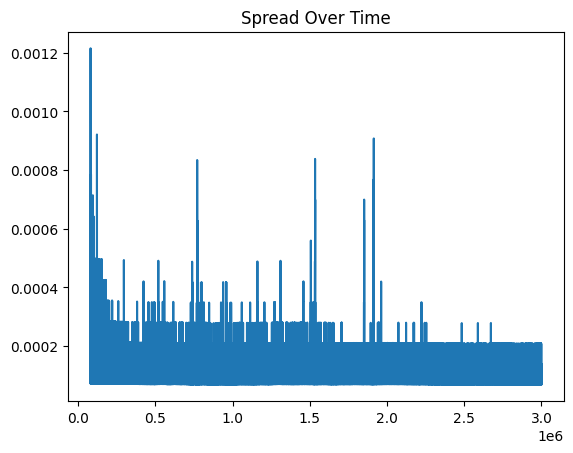

In [16]:
add_spread(xdf)
xdf['spread'].plot(title='Spread Over Time')

### calculate imbalance

In [17]:
#| export
def calc_bid_weight(row):
    return  np.array([row['mid']/(row['mid']-row[f'bid_px_0{i}'])*row[f'bid_sz_0{i}'] for i in range(0,10)]).sum(axis=0)
def calc_ask_weight(row): 
    return np.array([row['mid']/(row[f'ask_px_0{i}']-row['mid'])*row[f'ask_sz_0{i}'] for i in range(0,10)]).sum(axis=0)    

def add_imbalance_columns(df):
    # want to calculate the amount but also how spread out it is
    df['mid'] = (df['bid_px_00']+df['ask_px_00'])/2
    df['bid_weight'] = calc_bid_weight(df)
    df['ask_weight'] = calc_ask_weight(df)
    df['bid_weight_log'] = np.log(df['bid_weight'])
    df['ask_weight_log'] = np.log(df['ask_weight'])


In [18]:
add_imbalance_columns(xdf)
xdf[['bid_weight', 'ask_weight', 'bid_weight_log', 'ask_weight_log']].describe()

,bid_weight,ask_weight,bid_weight_log,ask_weight_log
count,2.919224e+06,2.919224e+06,2.919224e+06,2.919224e+06
mean,3.723545e+07,7.937142e+07,1.717434e+01,1.740215e+01
std,4.685932e+07,2.352555e+08,6.594639e-01,9.913230e-01
min,1.238872e+06,6.444875e+05,1.402971e+01,1.337621e+01
25%,1.944082e+07,1.911199e+07,1.678289e+01,1.676583e+01
50%,2.819848e+07,2.942520e+07,1.715478e+01,1.719736e+01
75%,4.139584e+07,5.546439e+07,1.753869e+01,1.783125e+01
max,3.027830e+09,1.012570e+10,2.183111e+01,2.303834e+01


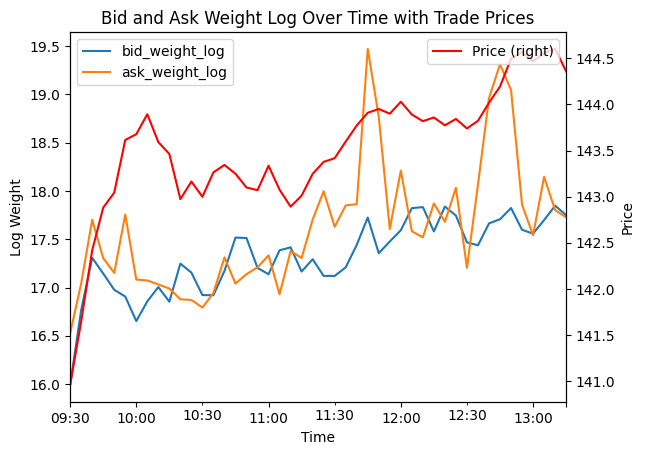

In [19]:

ax = xdf.set_index('ts_event')[['bid_weight_log', 'ask_weight_log']].resample('5min').mean().plot()
xdf[xdf['action'] == 'T'].set_index('ts_event')['price'].resample('5min').mean().plot(ax=ax, secondary_y=True, color='r', label='Price')
ax.set_xlabel('Time')
ax.set_ylabel('Log Weight')
ax.right_ax.set_ylabel('Price')
ax.set_title('Bid and Ask Weight Log Over Time with Trade Prices')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')
plot.show()

### Calculating trades on the bid and ask side


In [20]:
#| export
def add_rolling_trades_cols(df):
    # add a column with a the traded size by row, with 0 for non trade rows
    # this makes the next calculation easier
    df["traded_bid_size"] = df["size"] * ((df["action"] == "T") & (df["side"] == "B"))
    df["traded_ask_size"] = df["size"] * ((df["action"] == "T") & (df["side"] == "A"))
    df["is_trade_bid"] = ((df["action"] == "T") & (df["side"] == "B")) * 1
    df["is_trade_ask"] = ((df["action"] == "T") & (df["side"] == "A")) * 1

    def add_rolling_trades_cols(period):
        # temporary dataset so we can reindex
        x = df[['ts_event', 'traded_bid_size', 'traded_ask_size', 'is_trade_bid', 'is_trade_ask']].copy()
        x['original_index'] = df.index
        x.set_index("ts_event", inplace=True)

        # calculate
        x[f'rolling_{period}_bid_size'] = x["traded_bid_size"].rolling(period).sum()
        x[f'rolling_{period}_ask_size'] = x["traded_ask_size"].rolling(period).sum()
        x[f'rolling_{period}_bid_cnt'] = x["is_trade_bid"].rolling(period).sum()
        x[f'rolling_{period}_ask_cnt'] = x["is_trade_ask"].rolling(period).sum()

        # merge back to original dataframe
        x.set_index("original_index", inplace=True)
        df[f'rolling_{period}_bid_size'] = x[f'rolling_{period}_bid_size']
        df[f'rolling_{period}_ask_size'] = x[f'rolling_{period}_ask_size']
        df[f'rolling_{period}_bid_cnt'] = x[f'rolling_{period}_bid_cnt']
        df[f'rolling_{period}_ask_cnt'] = x[f'rolling_{period}_ask_cnt']


    add_rolling_trades_cols('30s')
    add_rolling_trades_cols('5min')

    # and cleanup
    _ = df.drop(columns=['traded_bid_size', 'traded_ask_size', 'is_trade_bid', 'is_trade_ask'])



In [21]:
add_rolling_trades_cols(xdf)

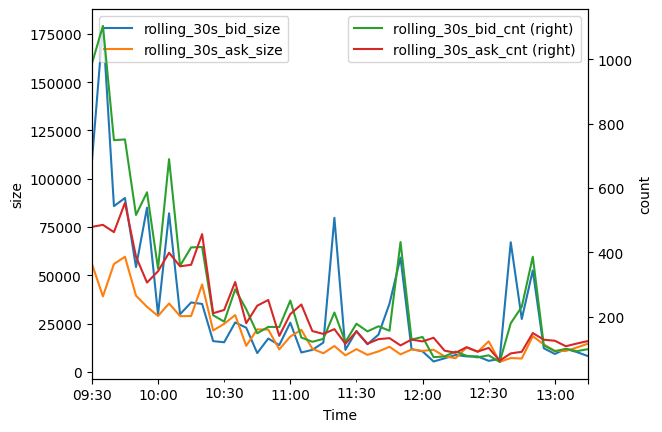

In [22]:
ax = xdf.set_index('ts_event')[['rolling_30s_bid_size', 'rolling_30s_ask_size']].resample('5min').mean().plot()
xdf.set_index('ts_event')[['rolling_30s_bid_cnt', 'rolling_30s_ask_cnt']].resample('5min').mean().plot(ax=ax, secondary_y=True)
ax.set_xlabel('Time')
ax.set_ylabel('size')
ax.right_ax.set_ylabel('count')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')
plot.show()

### Identify the stop price and location (index) for each row

In [ ]:
#| export
def calc_stop_loss_indices(df):
    # reduce dataset
    rdf = df[df['action'] == 'A'].sample(n=day_sample_count)
    
    stop_loss_currency = stop_loss_tick * tick_size - (tick_size / 10.0)  # substract 1/10 tick otherwise I get issues with floating point approximations
    
    rdf['hedge_buy_stop_idx'] = rdf.apply(lambda row: df.index[(df.index > row.name) & (df['ask_px_00'] >= row['ask_px_00']+ stop_loss_currency )].min(), axis=1)
    rdf['hedge_sell_stop_idx'] = rdf.apply(lambda row: df.index[(df.index > row.name) & (df['bid_px_00'] <= row['bid_px_00']- stop_loss_currency)].min(), axis=1)
    # add columns with the stop loss prices, will come handy when we introduce latency

    rdf['hedge_buy_stop_prc'] = rdf.loc[rdf['hedge_buy_stop_idx'].notnull()]['ask_px_00']
    rdf['hedge_sell_stop_prc'] = rdf.loc[rdf['hedge_sell_stop_idx'].notnull()]['bid_px_00']

    # convert idexes to int

    rdf['hedge_buy_stop_idx'] = rdf['hedge_buy_stop_idx'].astype('int', errors='ignore')
    rdf['hedge_sell_stop_idx'] = rdf['hedge_sell_stop_idx'].astype('int', errors='ignore')
    return rdf


In [93]:
rdf = calc_stop_loss_indices(xdf)
rdf.shape

(5000, 110)

### Test

In [94]:
idx = 0

In [95]:
idx = idx + 1
print(f"index: {rdf.iloc[idx].name} stop: {rdf.iloc[idx]['hedge_buy_stop_idx']}")
display_around(rdf.iloc[idx].name, int(rdf.iloc[idx]['hedge_buy_stop_idx']) - rdf.iloc[idx].name + 8)


index: 2157174 stop: 2157197.0
2076398


,action,side,price,size,bid_sz_00,bid_px_00,ask_px_00,ask_sz_00,bid_sz_01,bid_px_01,ask_px_01,ask_sz_01,sequence
2157173,C,B,143.25,25,320,143.25,143.26,365,675,143.24,143.27,465,292017206
2157174,A,B,143.25,25,345,143.25,143.26,365,675,143.24,143.27,465,292017718
2157175,C,A,143.27,100,345,143.25,143.26,365,675,143.24,143.27,365,292017942
2157176,C,A,143.28,300,345,143.25,143.26,365,675,143.24,143.27,365,292018353
2157177,A,A,143.29,300,345,143.25,143.26,365,675,143.24,143.27,365,292018356
2157178,A,A,143.26,500,345,143.25,143.26,865,675,143.24,143.27,365,292018748
2157179,A,B,143.25,100,445,143.25,143.26,865,675,143.24,143.27,365,292018750
2157180,A,B,143.25,100,545,143.25,143.26,865,675,143.24,143.27,365,292019325
2157181,C,B,143.25,25,520,143.25,143.26,865,675,143.24,143.27,365,292019561
2157182,A,B,143.25,25,545,143.25,143.26,865,675,143.24,143.27,365,292019562


### Calculate optimal hedge price

In [108]:
#| export
def calculate_ideal_hedge(df, rdf):
    # fix NaN values
    rdf['hedge_buy_stop_idx'] = rdf['hedge_buy_stop_idx'].where(~rdf['hedge_buy_stop_idx'].isna(), rdf.index)
    rdf['hedge_sell_stop_idx'] = rdf['hedge_sell_stop_idx'].where(~rdf['hedge_sell_stop_idx'].isna(), rdf.index)

    rdf['hedge_buy_stop_prc'] = rdf['hedge_buy_stop_prc'].where(~rdf['hedge_buy_stop_prc'].isna(), rdf['ask_px_00'])
    rdf['hedge_sell_stop_prc'] = rdf['hedge_sell_stop_prc'].where(~rdf['hedge_sell_stop_prc'].isna(), rdf['bid_px_00'])

    def optimal_buy_price(row):
        idx = df.index.get_loc(row.name)
        return df.iloc[idx:idx+1+row['hedge_buy_stop_idx']]['ask_px_00'].min()

    def optimal_sell_price(row):
        idx = df.index.get_loc(row.name)
        return df.iloc[idx:idx+1+row['hedge_sell_stop_idx']]['bid_px_00'].max()

    # calculate ideal position between current point and stop loss point 
    rdf['ideal_buy_price'] = rdf.apply(optimal_buy_price, axis=1)
    rdf['ideal_sell_price'] = rdf.apply(optimal_sell_price, axis=1)

    rdf['ideal_buy_price_spread'] = (rdf['ideal_buy_price'] - rdf['bid_px_00']) / (rdf['ask_px_00'] - rdf['bid_px_00'])
    rdf['ideal_sell_price_spread'] = -(rdf['ideal_sell_price'] - rdf['ask_px_00']) / (rdf['ask_px_00'] - rdf['bid_px_00'])

In [109]:
calculate_ideal_hedge(xdf, rdf)


In [110]:

rdf[['ideal_buy_price_spread', 'ideal_buy_price', 'bid_px_00', 'ask_px_00']]
rdf[rdf.ideal_buy_price_spread<0][['ideal_buy_price_spread', 'ideal_buy_price', 'bid_px_00', 'ask_px_00']]
rdf[rdf.ideal_sell_price_spread<0][['ideal_sell_price_spread', 'ideal_sell_price', 'bid_px_00', 'ask_px_00']]

,ideal_sell_price_spread,ideal_sell_price,bid_px_00,ask_px_00
2793401,-62.0,144.73,144.10,144.11
2157174,-147.0,144.73,143.25,143.26
259698,-78.5,143.24,141.65,141.67
1994051,-91.5,144.73,142.88,142.90
1123748,-36.0,143.97,143.60,143.61
...,...,...,...,...
1687168,-148.0,144.73,143.24,143.25
2395394,-80.0,144.73,143.92,143.93
257960,-83.5,143.24,141.55,141.57
1156243,-13.0,143.80,143.52,143.54


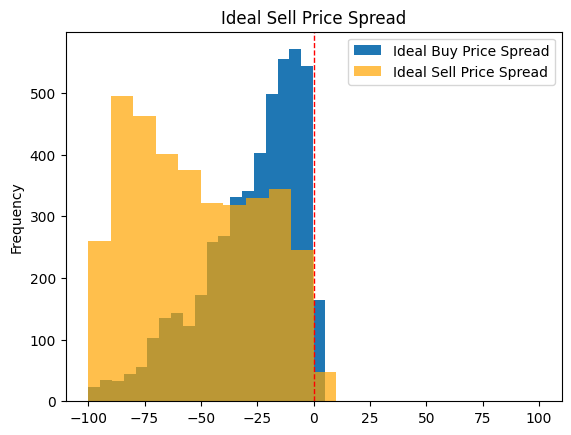

In [111]:
_ = rdf['ideal_buy_price_spread'].plot(kind='hist', title='Ideal Buy Price Spread', bins=20, range=(-100, 5))
rdf['ideal_sell_price_spread'].plot(kind='hist', title='Ideal Sell Price Spread', bins=20, range=(-100, 100), color='orange', alpha=0.7, ax=plot.gca())
plot.axvline(0, color='red', linestyle='dashed', linewidth=1)  # Add a vertical line at 0 for clarity
plot.legend(['Ideal Buy Price Spread', 'Ideal Sell Price Spread'])

#### Isolate buy and sell into 2 rows

In [112]:
#| export
def split_buy_sell(df):
    def split_side(side):
        rdf_side = df.copy()
        rdf_side['is_buy'] = True
        rdf_side['ideal_price'] = rdf_side[f'ideal_{side}_price']
        rdf_side['ideal_price_spread'] = rdf_side[f'ideal_{side}_price_spread']
        rdf_side['hedge_stop_prc'] = rdf_side[f'hedge_{side}_stop_prc']
        rdf_side.drop(columns=[f'ideal_{side}_price'], inplace=True)
        return rdf_side

    rdf_buy = split_side('buy')
    rdf_sell = split_side('sell')

    rdf_combined = pd.concat([rdf_buy, rdf_sell])
    return rdf_combined


In [113]:
rdf_combined = split_buy_sell(rdf)
rdf_combined[['is_buy','ideal_price']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 2793401 to 320707
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   is_buy       10000 non-null  bool   
 1   ideal_price  10000 non-null  float64
dtypes: bool(1), float64(1)
memory usage: 166.0 KB


In [114]:
len(rdf.columns)

114

#### cleanup columns

In [115]:
#| export
def cleanup_columns(df):
    for i in range(1, 10):
        df.drop(columns=[f'bid_px_0{i}', f'ask_px_0{i}'], inplace=True)
    for i in range(0, 10):
        df.drop(columns=[f'bid_sz_0{i}', f'ask_sz_0{i}'], inplace=True)
        df.drop(columns=[f'bid_ct_0{i}', f'ask_ct_0{i}'], inplace=True)

In [116]:
cleanup_columns(rdf_combined)

#### Save result

In [117]:
if is_notebook():
    os.makedirs(save_dir, exist_ok=True)
    rdf_combined.to_csv(save_dir / 'rdf_output.csv', index=False)

In [ ]:
#| export
if not is_notebook():
    from pathlib import Path
    import time

    def do_all(date):
        start_time = time.time()
        print("Step 1: Loading data")
        df = load_data(date)
        print(f"Step 2: Adjusting for time (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        df = adjust_for_time(df)
        print(f"Step 3: Dropping NA (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        drop_na(df)
        print(f"Step 4: Adding spread (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        add_spread(df)
        print(f"Step 5: Adding imbalance columns (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        add_imbalance_columns(df)
        print(f"Step 6: Calculating stop loss indices (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        rdf = calc_stop_loss_indices(df)
        print(f"Step 7: Calculating ideal hedge (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        calculate_ideal_hedge(df, rdf)
        print(f"Step 8: Splitting buy and sell (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        rdf_combined = split_buy_sell(rdf)
        print(f"Step 9: Cleaning up columns (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        cleanup_columns(rdf_combined)
        print(f"Step 10: Saving to CSV (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        rdf_combined.to_csv(save_dir / f'rdf_output_{date}.csv', index=False)

    # Define the directory and pattern
    directory = Path("../market")
    pattern = "*mbp-10*"
    print("here")
    # Iterate over files matching the pattern
    for file_path in directory.glob(pattern):
        print(file_path)
        # Extract the date from the filename
        date_str = file_path.name[10:18]
        print(f"Extracted date: {date_str}")
        do_all(date_str)

In [121]:
#| hide
import nbdev; nbdev.nbdev_export()

### search of one order triggering more than one execution

### search of iceberg orders

### Consider latency

### Spread could be calculated based on an average spread instead of the immediate value